# Here is a small-scale example for training deep-learning models (compact convolutional transformer) for P/S wave arrival picking

# The EQCCT architecture is the baseline deep-learning model that is used by Texas Seismological Network (TexNet) for daily earthquake monitoring

# This example was prepared by Yangkang Chen, Feb 20, 2025.

# It's working now

# See the dramatic change of training (including validation) samples from 1000, to 10000, to 50000 (latest for this notebook), to higher, to understand the magics and limitations of deep learning.

In [1]:
# References:
# Saad, O.M., Chen, Y.F., Siervo, D., Zhang, F., Savvaidis, A., Huang, G., Igonin, N., Fomel, S., and Chen, Y., (2023), as a highly accurate and generalizable machine-learning seismic event detection algorithm, IEEE TGRS.
# Chen et al., 2024, Near Real‐Time Earthquake Monitoring in Texas Using the Highly Precise Deep Learning Phase Picker, Earth and Space Science, 11, e2024EA003890.
# Cui, Y., M. Bai, J. Wu, and Y. Chen, 2025, Earthquake signal detection using a multiscale feature fusion network with hybrid attention mechanism, GJI, 988-1008


In [2]:
#conda activate eqp (eqpolarity or eqpicking environment)

# First set up the environment and install the dependency packages (tested on CPU machine)
# 
# conda create -n eqp python=3.11.7
# conda activate eqp
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# Or, on machine with a GPU setup, use the following commands
# conda create -n eqp python=3.10.14
# conda activate eqp
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
# Make sure LD_LIBRARY_PATH includes ~/anaconda3/envs/eqp/lib (libcudnn.so.8)


# import library
import numpy as np
import h5py


In [3]:
# Load the TXED dataset
# please down load the TXED from: https://drive.google.com/drive/folders/1WXVB8ytNB4bOaZ97oq6OmMRyAEg95trp?usp=sharing
f_txed = h5py.File("/Users/chenyk/DATALIB/TXED/TXED_20231111.h5", 'r')
txed_signal_id = np.load("/Users/chenyk/DATALIB/TXED/ID_20231111.npy", 'r')[0:100000].copy()
np.random.seed(20232425)
np.random.shuffle(txed_signal_id)
txed_signal_id=txed_signal_id[0:50000]
print(txed_signal_id[0:10]) #see if the random IDs are the same


['texnet2022nlpv_PB31_EV' 'texnet2021bbcd_POST_EV'
 'texnet2020znsu_OG02_EV' 'texnet2021ojgr_PB16_EV'
 'texnet2021ghba_EF04_EV' 'texnet2020yuzo_MB07_EV'
 'texnet2021gqdj_MB07_EV' 'texnet2022mqlw_PB03_EV'
 'texnet2023ihss_PB44_EV' 'texnet2021wmup_PB09_EV']


# Design a DL architecture for P/S arrival picking

In [4]:
# Below example is from 
# Cui, Y., M. Bai, J. Wu, and Y. Chen, 2025, Earthquake signal detection using a multiscale feature fusion network with hybrid attention mechanism, GJI, 988-1008
#

from keras.layers import Input, Dense, Conv1D, Dropout, Activation, Flatten, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler, CSVLogger
from keras.layers import concatenate,LeakyReLU,GlobalAveragePooling1D,Multiply,Reshape,Lambda,Add,GRU
from keras.layers import BatchNormalization,UpSampling1D,Layer,Embedding,MultiHeadAttention,LayerNormalization
from keras.models import Model
# from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras import backend as K
import tensorflow as tf
import numpy as np

image_size = 6000  
patch_size = 40  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size)
projection_dim = 40
stochastic_depth_rate = 0.1
transformer_layers = 4
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers

class Patches(Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size' : self.patch_size, 
            
        })
        
        return config
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, 1, 1],
            strides=[1, self.patch_size, 1, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches' : self.num_patches, 
            'projection_dim' : projection_dim, 
            
        })
        
        return config
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        #print(patch,positions)
        #temp = self.position_embedding(positions)
        #temp = tf.reshape(temp,(1,int(temp.shape[0]),int(temp.shape[1])))
        #encoded = Add()([self.projection(patch), temp])
        #print(temp,encoded)
        
        return encoded

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def convF1(inpt, D1, fil_ord, Dr):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    #filters = inpt._keras_shape[channel_axis]
    filters = int(inpt.shape[-1])
    
    #infx = Activation(tf.nn.gelu')(inpt)
    pre = Conv1D(filters,  fil_ord, strides =(1), padding='same',kernel_initializer='he_normal')(inpt)
    pre = BatchNormalization()(pre)    
    pre = Activation(tf.nn.gelu)(pre)
    
    #shared_conv = Conv1D(D1,  fil_ord, strides =(1), padding='same')
    
    inf  = Conv1D(filters,  fil_ord, strides =(1), padding='same',kernel_initializer='he_normal')(pre)
    inf = BatchNormalization()(inf)    
    inf = Activation(tf.nn.gelu)(inf)
    inf = Add()([inf,inpt])
    
    inf1  = Conv1D(D1,  fil_ord, strides =(1), padding='same',kernel_initializer='he_normal')(inf)
    inf1 = BatchNormalization()(inf1)  
    inf1 = Activation(tf.nn.gelu)(inf1)    
    encode = Dropout(Dr)(inf1)

    return encode

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        #x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    return x
    
def create_cct_modelP(inputs):

    inputs1 = convF1(inputs,   10, 11, 0.1)
    inputs1 = convF1(inputs1, 20, 11, 0.1)
    inputs1 = convF1(inputs1, 40, 11, 0.1)
    
    inputreshaped = Reshape((6000,1,40))(inputs1)
    # Create patches.
    patches = Patches(patch_size)(inputreshaped)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #print('done')
        
    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):

        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
    

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = Add()([x3, x2])

    # Apply sequence pooling.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation)

    return representation


#The S Model
def create_cct_modelS(inputs):

    inputs1 = convF1(inputs,   10, 11, 0.1)
    inputs1 = convF1(inputs1, 20, 11, 0.1)
    inputs1 = convF1(inputs1, 40, 11, 0.1)
    
    inputreshaped = Reshape((6000,1,40))(inputs1)

    # Create patches.
    patches = Patches(patch_size)(inputreshaped)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #print('done')
        
    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        encoded_patches = convF1(encoded_patches, 40,11, 0.1)
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        attention_output = convF1(attention_output, 40,11, 0.1)
    

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = Add()([x3, x2])

    # Apply sequence pooling.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    #print(representation)

    return representation
    
# Model CCT
inputs = Input(shape=(6000, 3))

#featuresP = create_cct_model(inputs)
#featuresS = create_cct_model(inputs)


#logitp  = Dense(6000 ,activation='sigmoid', kernel_initializer='he_normal',name='picker_P1')(featuresP)
#logits  = Dense(6000 ,activation='sigmoid', kernel_initializer='he_normal',name='picker_S1')(featuresS)
#logitp = Reshape((6000,1), name='picker_P')(logitp)
#logits = Reshape((6000,1), name='picker_S')(logits)


featuresP = create_cct_modelP(inputs)
featuresP = Reshape((6000,1))(featuresP)

featuresS = create_cct_modelS(inputs)
featuresS = Reshape((6000,1))(featuresS)

logitp  = Conv1D(1,  15, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)
logits  = Conv1D(1,  15, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_S')(featuresS)



modelP = Model(inputs=[inputs], outputs=[logitp])
modelS = Model(inputs=[inputs], outputs=[logits])

picking_model = Model(inputs=[inputs], outputs=[logitp,logits])
picking_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000, 3)]            0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 6000, 3)              102       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 6000, 3)              12        ['conv1d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_9 (Activation)   (None, 6000, 3)              0         ['batch_normalization_9[

In [5]:
## Define a band-pass filter

from scipy.signal import butter, lfilter, lfilter_zi

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
    
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    zi = lfilter_zi(b, a)
    y,zo = lfilter(b, a, data, zi=zi*data[0])
    return y

def generate_first_arrival_labels(p_indx, s_indx, sample_num):
    """
    Generate labels for P-wave and S-wave first arrival picking.

    Parameters:
        p_indx (float): Arrival time of P-wave.
        s_indx (float): Arrival time of S-wave.
        sample_num (float): Total duration of the seismic signal.

    Returns:
        np.array: Array of labels indicating P-wave, S-wave, or neither.
    """
    all_time = np.linspace(0, sample_num, sample_num)
    #print(sample_num, all_time.shape)
    p_wave_arrival_time = p_indx  # P-wave arrival time (in seconds)
    s_wave_arrival_time = s_indx  # S-wave arrival time (in seconds)
    
    # Create Gaussian-shaped labels for P-wave and S-wave arrivals
    sigma = 10 # Standard deviation of the Gaussian
    p_wave_label = np.exp(-(all_time - p_wave_arrival_time)**2 / (2 * sigma**2))  # Gaussian label for P-wave
    s_wave_label = np.exp(-(all_time - s_wave_arrival_time)**2 / (2 * sigma**2))  # Gaussian label for S-wave

    return p_wave_label, s_wave_label

In [6]:
# obtain the P- and S-wave arrivals
P_arrival_list = []
S_arrival_list = []
print('-----------arrival time calculation begin-------------------')
for key in txed_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        P_arrival_list.append(int(dataset.attrs['p_arrival_sample']))
        S_arrival_list.append(int(dataset.attrs['s_arrival_sample']))
P_arrival_list = np.array(P_arrival_list)
S_arrival_list = np.array(S_arrival_list)
P_phase_label_indx = P_arrival_list
S_phase_label_indx = S_arrival_list
P_phase_label_indx = np.reshape(P_phase_label_indx, [P_phase_label_indx.shape[0], 1])
S_phase_label_indx = np.reshape(S_phase_label_indx, [S_phase_label_indx.shape[0], 1])
phase_label_indx = np.concatenate([P_phase_label_indx, S_phase_label_indx], axis=-1)
print('-----------arrival time calculation end-------------------')
print(f'shape of arrivals: {P_arrival_list.shape}')


# apply the bandpass and normalize to each waveform
signal_list = []
print('-----------signal format convert begin-------------------')
for key in txed_signal_id:
    if key in f_txed:   
        dataset = f_txed.get(key)
        datas = dataset['data']
        datas = np.array(datas)
        datas_0 = bandpass_filter(datas[:,0], 1, 45, 100, order=3)
        datas_1 = bandpass_filter(datas[:,1], 1, 45, 100, order=3)
        datas_2 = bandpass_filter(datas[:,2], 1, 45, 100, order=3)
        datas = np.vstack([datas_0, datas_1, datas_2])
        signal_list.append(datas) 
signal_values = np.array(signal_list)
bp_signal= np.transpose(signal_values, [0, 2, 1])


#Normalized trace-by-trace
max_values_per_event = np.max(bp_signal, axis=1)
# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = bp_signal / max_values_per_event[:, np.newaxis, :]
print('-----------signal format convert finish-------------------')
print(bp_signal.shape)

p_wave_label = []
s_wave_label = []
for i in range (normalized_phase_data.shape[0]):
    # Example usage:
    p_indx = P_arrival_list[i]  # Arrival time of P-wave (in seconds)
    s_indx = S_arrival_list[i]  # Arrival time of S-wave (in seconds)    
    sample_num = 6000  # Sampling rate of seismic signal (in Hz)
    #print(f'Processed_num:{i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    if i % 5000 == 0:
        print(f'Processed_num: {i}\t P_arrival_time: {p_indx}\t S_arrival_time: {s_indx}\t sample_num: {sample_num}')
    
    # Generate labels for P-wave and S-wave first arrival picking
    p_labels, s_labels = generate_first_arrival_labels(p_indx, s_indx, sample_num)
    p_wave_label.append(p_labels)  
    s_wave_label.append(s_labels)
p_wave_label = np.array(p_wave_label)
s_wave_label = np.array(s_wave_label)
phase_label = np.concatenate([np.reshape(p_wave_label, [p_wave_label.shape[0], p_wave_label.shape[1], 1]), \
                              np.reshape(s_wave_label, [s_wave_label.shape[0], s_wave_label.shape[1], 1])], axis=-1)


-----------arrival time calculation begin-------------------
-----------arrival time calculation end-------------------
shape of arrivals: (50000,)
-----------signal format convert begin-------------------
-----------signal format convert finish-------------------
(50000, 6000, 3)
Processed_num: 0	 P_arrival_time: 1023	 S_arrival_time: 1563	 sample_num: 6000
Processed_num: 5000	 P_arrival_time: 524	 S_arrival_time: 707	 sample_num: 6000
Processed_num: 10000	 P_arrival_time: 390	 S_arrival_time: 747	 sample_num: 6000
Processed_num: 15000	 P_arrival_time: 995	 S_arrival_time: 1334	 sample_num: 6000
Processed_num: 20000	 P_arrival_time: 588	 S_arrival_time: 723	 sample_num: 6000
Processed_num: 25000	 P_arrival_time: 649	 S_arrival_time: 952	 sample_num: 6000
Processed_num: 30000	 P_arrival_time: 848	 S_arrival_time: 1486	 sample_num: 6000
Processed_num: 35000	 P_arrival_time: 970	 S_arrival_time: 1189	 sample_num: 6000
Processed_num: 40000	 P_arrival_time: 175	 S_arrival_time: 564	 sample

In [7]:
from sklearn.model_selection import train_test_split

# Data splitting for EQ detection
X_train_phase, X_test_phase, y_train_phase, y_test_phase = train_test_split(normalized_phase_data, phase_label, test_size=0.15, random_state=202404)
print('X_train_phase shape', X_train_phase.shape, 'X_test_phase shape', X_test_phase.shape)

X_train_phase shape (42500, 6000, 3) X_test_phase shape (7500, 6000, 3)


In [8]:
import os
## Start the training process
log_path = './training_model/logs/'
save_model_path = './training_model/'
fig_path = './figs/'

os.makedirs(save_model_path, exist_ok=True)
os.makedirs(log_path , exist_ok=True)
os.makedirs(fig_path , exist_ok=True)

val_splitting_rate = 0.05 # ratio of validation data
learning_rate = 0.001 # Specify the learning rate
phase_batch = 256 # batch size for picking
phase_epoch = 20 #number of iterations

optimizer = Adam(learning_rate=learning_rate)

# train the picking model
picking_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

csv_logger = CSVLogger(f'{log_path}EQ_picking_logs.csv')


# Addig stopping condition
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'{save_model_path}EQ_picking_best_model_new.h5', monitor='val_loss', mode='min', save_best_only=True)


# Tic-Toc
import time
start=time.time()
history_phase = picking_model.fit(X_train_phase, [y_train_phase[:,:,0],y_train_phase[:,:,1]], verbose=1, epochs=phase_epoch,
                                  validation_split=val_splitting_rate, shuffle=True, batch_size=phase_batch, callbacks=[csv_logger, es, mc])
end = time.time()
running_time = end - start
print('time cost od picking model: %.4f sec' % running_time)



Epoch 1/20
158/158 [==============================] - 617s 4s/step - loss: 1.0966 - picker_P_loss: 0.5417 - picker_S_loss: 0.5548 - picker_P_accuracy: 0.8168 - picker_S_accuracy: 0.7306 - val_loss: 0.9024 - val_picker_P_loss: 0.2797 - val_picker_S_loss: 0.6227 - val_picker_P_accuracy: 0.9560 - val_picker_S_accuracy: 0.6655
Epoch 2/20


/opt/anaconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 7292s 46s/step - loss: 0.2696 - picker_P_loss: 0.1351 - picker_S_loss: 0.1346 - picker_P_accuracy: 0.9560 - picker_S_accuracy: 0.9492 - val_loss: 0.6222 - val_picker_P_loss: 0.0626 - val_picker_S_loss: 0.5596 - val_picker_P_accuracy: 0.9560 - val_picker_S_accuracy: 0.7309
Epoch 3/20
158/158 [==============================] - 10141s 65s/step - loss: 0.0940 - picker_P_loss: 0.0456 - picker_S_loss: 0.0484 - picker_P_accuracy: 0.9560 - picker_S_accuracy: 0.9541 - val_loss: 0.0716 - val_picker_P_loss: 0.0358 - val_picker_S_loss: 0.0358 - val_picker_P_accuracy: 0.9560 - val_picker_S_accuracy: 0.9559
Epoch 4/20
158/158 [==============================] - 1037s 7s/step - loss: 0.0653 - picker_P_loss: 0.0320 - picker_S_loss: 0.0333 - picker_P_accuracy: 0.9560 - picker_S_accuracy: 0.9555 - val_loss: 0.0585 - val_picker_P_loss: 0.0291 - val_picker_S_loss: 0.0293 - val_picker_P_accuracy: 0.9560 - val_picker_S_accuracy: 0.9560
Epoch 5/20
158/158 [==========

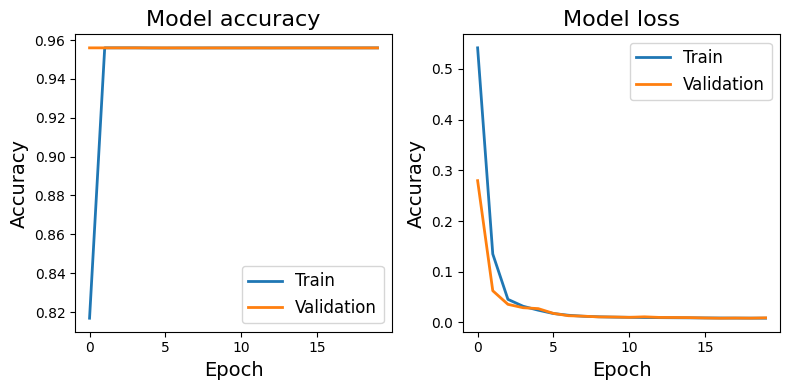

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(history_phase.history['picker_P_accuracy'], linewidth=2)
plt.plot(history_phase.history['val_picker_P_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='lower right',fontsize='large', title_fontsize='large')
# plt.show()

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_phase.history['picker_P_loss'], linewidth=2)
plt.plot(history_phase.history['val_picker_P_loss'], linewidth=2)
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize='large', title_fontsize='large')
plt.tight_layout()
plt.savefig(f'{fig_path}Acc_and_loss_curves_detection.png')
plt.show()

In [10]:
history_phase.history

{'loss': [1.0965642929077148,
  0.26964253187179565,
  0.09404262900352478,
  0.06531626731157303,
  0.05385808274149895,
  0.0446523055434227,
  0.034732967615127563,
  0.02912694774568081,
  0.025985920801758766,
  0.02392727881669998,
  0.022659003734588623,
  0.02246665582060814,
  0.021039023995399475,
  0.020291268825531006,
  0.019816577434539795,
  0.019315987825393677,
  0.01891988143324852,
  0.018645528703927994,
  0.01838957518339157,
  0.018173037096858025],
 'picker_P_loss': [0.5417167544364929,
  0.13507157564163208,
  0.04564020410180092,
  0.03203069418668747,
  0.02423470839858055,
  0.017661288380622864,
  0.014238353818655014,
  0.012252508662641048,
  0.011211663484573364,
  0.010555506683886051,
  0.010171658359467983,
  0.009819619357585907,
  0.009542468003928661,
  0.009326529689133167,
  0.009150701574981213,
  0.008954701945185661,
  0.00879331212490797,
  0.00867441575974226,
  0.00859222561120987,
  0.008498224429786205],
 'picker_S_loss': [0.55484783649444

In [11]:
from keras.models import load_model

# picking_model = load_model(f'{save_model_path}EQ_picking_best_model_new.h5')
test_phase_out = picking_model.predict(X_test_phase)



235/235 [==============================] - 36s 149ms/step


In [12]:
test_phase_out=np.concatenate(test_phase_out,axis=2);

In [13]:
test_phase_out.shape

(7500, 6000, 2)

In [14]:
def to_numpy(array):
    array = np.array(array)
    return array


pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(test_phase_out[i, :, 0])
    pre_ind_s = np.argmax(test_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_test_phase[i, :, 0])
    lab_ind_s = np.argmax(y_test_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s = err_indx_s/100

# xx = 2
# err_indx_p[(err_indx_p > xx) | (err_indx_p < -xx)] = 0
# err_indx_s[(err_indx_s > xx) | (err_indx_s < -xx)] = 0

mae_p = np.mean(np.abs(err_indx_p - np.mean(err_indx_p)))
sigma_p = np.std(err_indx_p)
mae_s = np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))
sigma_s = np.std(err_indx_s)

print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')


MAE and $sigma$ of p: 0.4432s	1.1303s
MAE and $sigma$ of s: 0.5242s	2.5841s


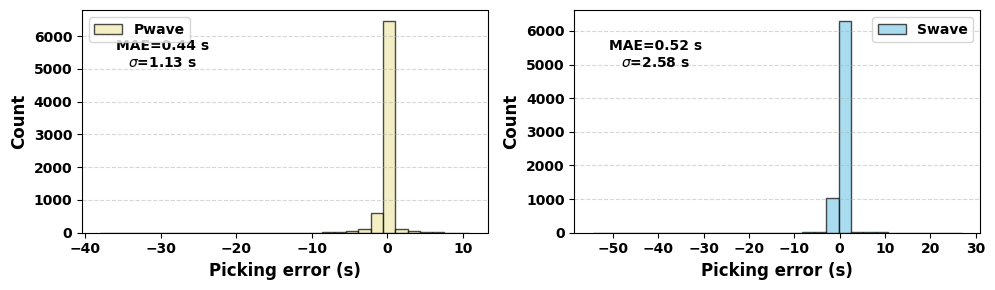

In [15]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_testing_data.png')
plt.show()

In [16]:
## Define fancy visualization functions

def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
    data = signal
    p_predict_indx = np.argmax(p_predict)
    s_predict_indx = np.argmax(s_predict)
    s_labels_indx = np.argmax(s_labels)
    p_labels_indx = np.argmax(p_labels)
    
    time = np.linspace(0, sample_num, sample_num)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(511)
    plt.plot(time, data[:,0], 'k',label='Z')
    ymin,ymax = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax1.get_ylim()
    print('ymin, ymax:', ymin, ymax)
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlim([0, 6000])
    ax1.set_xticklabels([])
    # ax1.set_xticks([])
    
    ax = fig.add_subplot(512) 
    plt.plot(time, data[:,1], 'k',label='N')
    # ymin,ymax = ax1.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    legend_properties = {'weight':'bold'}
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(513) 
    plt.plot(time, data[:,2], 'k',label='E')
    # ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ymin,yma = ax.get_ylim()
    ax.set_xticklabels([])
    # ax.set_xticks([])
    
    ax = fig.add_subplot(514) 
    plt.plot(time, p_predict, label='P-wave predicted', linestyle='--')
    plt.plot(time, s_predict, label='S-wave predicted', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    # plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(515) 
    plt.plot(time, p_labels, label='P-wave label', linestyle='--')
    plt.plot(time, s_labels, label='S-wave label', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    plt.tight_layout()

(7500, 6000, 2)
ymin, ymax: -0.8557484582099323 1.088368974200473


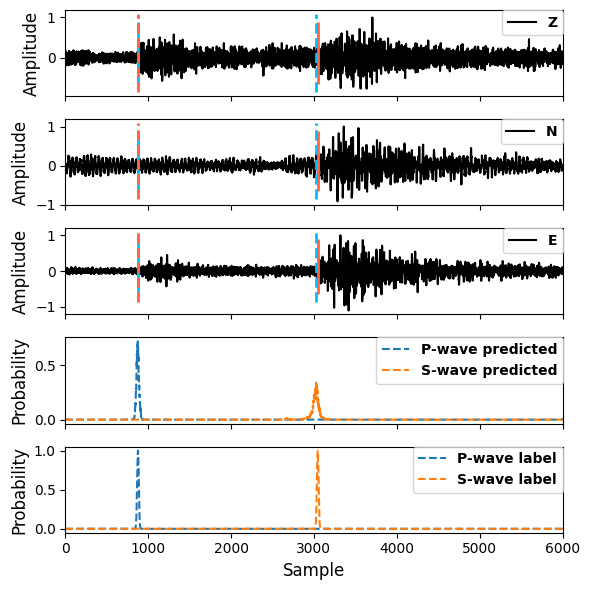

In [17]:
print(test_phase_out.shape)

m = 10

# def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
plot_labels_signals(X_test_phase[m, :, :], p_predict=test_phase_out[m, :, 0], s_predict=test_phase_out[m, :, 1], p_labels=y_test_phase[m, :, 0], s_labels=y_test_phase[m, :, 1], sample_num=6000)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.pdf', bbox_inches="tight", dpi=300)
# plt.savefig(f'./figs/phase_picking/p_and_s_wave/p_and_swave_picking_testing_num_{m}.png', bbox_inches="tight", dpi=300)
plt.show()



In [18]:
train_phase_out = picking_model.predict(X_train_phase)

train_phase_out=np.concatenate(train_phase_out,axis=2)
print(train_phase_out.shape)

1329/1329 [==============================] - 167s 125ms/step
(42500, 6000, 2)


In [19]:
pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(train_phase_out[i, :, 0])
    pre_ind_s = np.argmax(train_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_train_phase[i, :, 0])
    lab_ind_s = np.argmax(y_train_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

pre_indx_p = to_numpy(pre_indx_p)
pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p_train = err_indx_p/100
err_indx_s = lab_indx_s - pre_indx_s
err_indx_s_train = err_indx_s/100


# xx = 2
# err_indx_p_train[(err_indx_p_train > xx) | (err_indx_p_train < -xx)] = 0
# err_indx_s_train[(err_indx_s_train > xx) | (err_indx_s_train < -xx)] = 0
mae_p = np.mean(np.abs(err_indx_p_train - np.mean(err_indx_p_train)))
sigma_p = np.std(err_indx_p_train)
mae_s = np.mean(np.abs(err_indx_s_train - np.mean(err_indx_s_train)))
sigma_s = np.std(err_indx_s_train)


print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s\nMAE and $sigma$ of s: {mae_s:.4f}s\t{sigma_s:.4f}s')

MAE and $sigma$ of p: 0.4434s	1.2269s
MAE and $sigma$ of s: 0.5171s	2.6283s


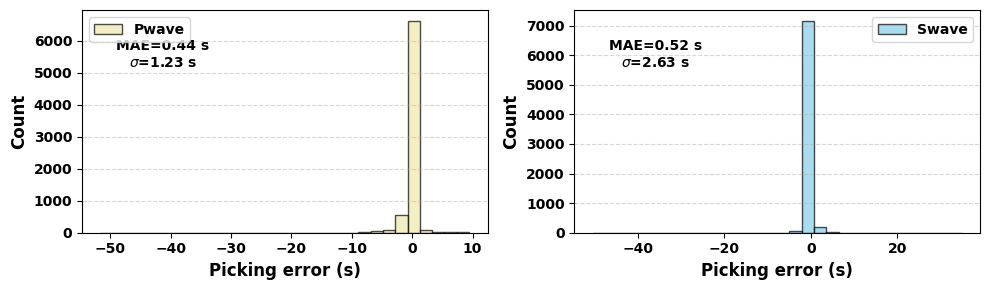

In [20]:
plt.figure(figsize=(10, 3))  # Set figure size
ax = plt.subplot(121)
plt.hist(err_indx_p_train, bins=30, color='palegoldenrod', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Pwave'], prop={'weight': 'bold'})

ax = plt.subplot(122)
plt.hist(err_indx_s_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_s:.2f} s\n$\sigma$={sigma_s:.2f} s', fontsize=10, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['Swave'], prop={'weight': 'bold'})

plt.tight_layout()

plt.savefig(f'{fig_path}Arrival_picking_training_data.png')
plt.show()

ymin, ymax: -1.047235223504832 1.0974873915954682


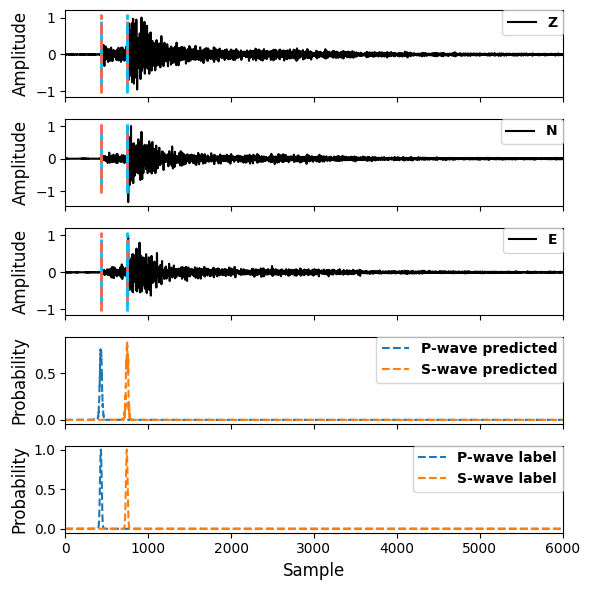

In [21]:
m = 600

plot_labels_signals(X_train_phase[m, :, :], p_predict=train_phase_out[m, :, 0], s_predict=train_phase_out[m, :, 1], p_labels=y_train_phase[m, :, 0], s_labels=y_train_phase[m, :, 1], sample_num=6000)
plt.show()

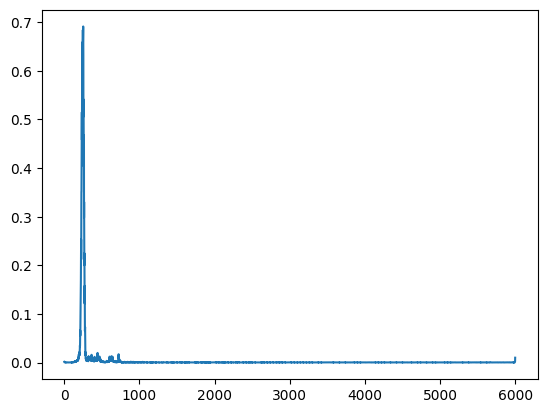

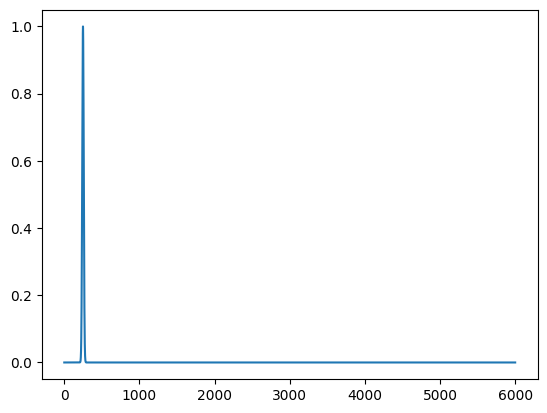

In [22]:
plt.figure()
plt.plot(test_phase_out[20, :, 0])

plt.figure()
plt.plot(y_test_phase[20, :, 0])

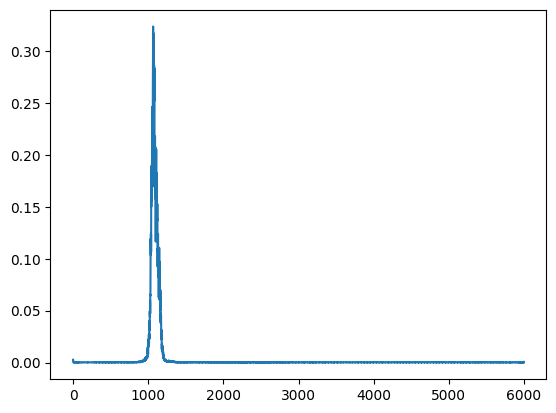

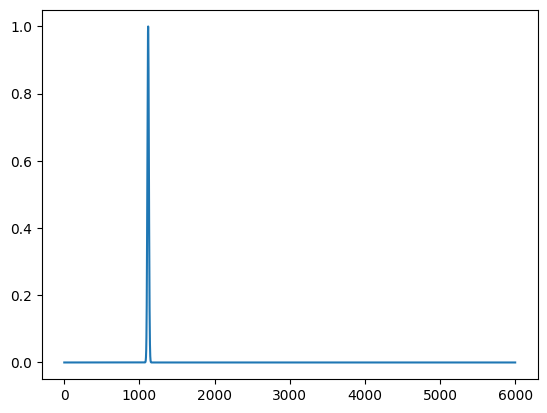

In [23]:
plt.figure()
plt.plot(test_phase_out[20, :, 1])

plt.figure()
plt.plot(y_test_phase[20, :, 1])